## U4.L2.5 - Challenge - Boston Marathon

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters.

In [53]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder


from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

from sklearn.model_selection import train_test_split

from sklearn import metrics
from itertools import cycle

import matplotlib.cm as cm

from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [2]:
boston2014 = pd.read_csv('Boston_results_2014.csv')

In [3]:
boston2014.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [4]:
boston2014.shape

(31984, 21)

In [5]:
boston2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


We have 31984 observations, with 21 features. We can see information about their performance, including timing from 5k, 10k, 20k, 25k, 30k, 35k, and 40k distances, and average pace. We can see information about each contestant, such as name, gender, age, and place of origin. A few categories represent administrative details about the marathon, such as assigned division. I could not find any document explaining what `genderdiv` represents.

$k$-means is a mathematically straightforward but computationally intensive hard-clustering method for grouping data into clusters of similar data points with similar variances.  It uses a cost function called the *inertia*, and the algorithm tries to choose means (called *centroids*) that minimize the inertia.  If you recall the lesson on linear regression, the formula for inertia may be familiar:

$$\sum(\bar{x}_c - x_i)^2$$

In words, the inertia is the sum of the squared differences between the centroid of a cluster (the mean $\bar{x}_c$) and the data points in the cluster ($x_i$).  The goal is to define cluster means so that the distance between a cluster mean and all the data points within the cluster is as small as possible.

Check columns for NULLs

In [6]:
categorical = ['gender','bib','ctz','state','country','city']

for column in categorical:
    print(boston2014[column].value_counts())

M    17617
F    14367
Name: gender, dtype: int64
29970    1
17498    1
10956    1
13656    1
2557     1
27420    1
13687    1
21762    1
28181    1
31677    1
24825    1
29032    1
26560    1
27048    1
24005    1
10543    1
35018    1
14867    1
34620    1
28997    1
30278    1
18112    1
34347    1
24222    1
6397     1
11907    1
15262    1
11648    1
33270    1
27971    1
        ..
30070    1
34299    1
22145    1
33998    1
31168    1
11459    1
6066     1
10246    1
30974    1
32424    1
28215    1
8434     1
12783    1
27989    1
30853    1
20472    1
15206    1
26318    1
26848    1
28085    1
2648     1
33415    1
10530    1
22275    1
32085    1
23942    1
16824    1
24148    1
17570    1
26767    1
Name: bib, Length: 31984, dtype: int64
GBR    171
CAN    143
USA    135
JPN     95
IRL     68
MEX     62
GER     55
FRA     45
AUS     43
CHN     39
ITA     30
NZL     27
NED     22
VEN     19
ESP     18
KOR     17
IND     15
SUI     13
COL     13
SWE     12
ARG     10
BRA     10

In [7]:
# Discover that some columns have other characters even if they seem to be numerical:
# pd.to_numeric( df['25k']) #errors='coerce')

In [8]:
#df['25k']=df['25k'].replace('-',np.nan)

* `Gender`:

is a useful feature that we can easily convert to binary for analysis purposes.

* `Bib`:

refers to the ranking for that divison. However, since the ranking system is not uniform across divisions, we cannot use this in our algorithm. Some values are strings, some values are numeric, and there is no way to standardize or separate these so we will drop this category from our analysis.

* `ctz` and `country`:

I am not sure what the difference is between ctz and country; the UK is the most common country for ctz, with Canada and USA after. For the country category, USA is the most common country by tenfold, and the frequencies are much higher.

Only American contestants have a value for state. Massachusetts is the most common state, with California and New York next. This makes sense because the marathon is held in Massachusetts. Because this feature doesn't apply to many of the contestants, it will likely not used in the final algorithm.
I doubt city will be a strong category since there are only a few contestants from each and far too many values. I will drop it at this time.


* `city`:

I doubt it will be a strong category since there are only a few contestants from each and far too many values. I will drop it at this time.

* `name`: 

I will also drop name because it should have no effect on the outcome.



Convert `object` columns that seem to be of numeric type.

Afterwards we check with `.info()` how many values have been replaced using `coerce`.

In [9]:
boston2014.genderdiv.value_counts()

9        4
3        4
11       4
2        4
8        4
6        4
1        4
7        4
4        4
5        4
10       4
36       3
33       3
39       3
41       3
13       3
42       3
34       3
26       3
21       3
25       3
24       3
17       3
37       3
27       3
40       3
29       3
19       3
38       3
12       3
        ..
14388    1
15293    1
16475    1
17381    1
14420    1
15338    1
16459    1
17330    1
15857    1
17397    1
14404    1
15354    1
15277    1
16443    1
17413    1
15245    1
15873    1
16427    1
15370    1
17314    1
14372    1
15261    1
17429    1
16411    1
15889    1
15386    1
17298    1
16395    1
17445    1
15147    1
Name: genderdiv, Length: 17575, dtype: int64

In [10]:
boston2014[['25k','10k','half','official','pace','30k','5k','genderdiv','20k','35k','40k']]=boston2014[['25k','10k','half','official','pace','30k','5k','genderdiv','20k','35k','40k']].apply(pd.to_numeric, errors='coerce' , axis=1)

In [11]:
boston2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31934 non-null float64
name         31984 non-null object
division     31984 non-null int64
25k          31768 non-null float64
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null float64
ctz          1244 non-null object
35k          31950 non-null float64
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31944 non-null float64
5k           31932 non-null float64
half         31912 non-null float64
20k          31933 non-null float64
country      31984 non-null object
city         31983 non-null object
40k          31945 non-null float64
dtypes: float64(11), int64(3), object(7)
memory usage: 5.1+ MB


In [12]:
pd.options.display.float_format = '{:,.2f}'.format
boston2014.describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,"31,934.00","31,984.00","31,768.00","31,984.00","31,984.00","31,984.00","31,950.00","31,984.00","31,984.00","31,944.00","31,932.00","31,912.00","31,933.00","31,945.00"
mean,51.80,"1,932.56",133.61,42.41,243.00,"8,051.04",196.86,"15,939.59",9.28,164.57,25.76,111.66,105.71,229.00
std,8.97,"1,715.23",25.60,11.32,52.30,"4,754.01",41.98,"9,232.98",1.99,33.95,4.33,21.06,19.78,49.16
min,16.62,1.00,45.80,18.00,80.60,1.00,67.42,1.00,3.08,56.45,7.75,38.03,36.10,76.10
25%,45.40,610.00,115.47,33.00,205.53,"3,972.00",167.12,"7,943.75",7.85,140.67,22.65,96.84,91.75,193.82
50%,50.33,"1,425.00",128.88,42.00,232.37,"7,970.00",188.17,"15,939.50",8.87,157.73,25.08,107.83,102.15,218.85
75%,57.17,"2,611.00",147.73,50.00,273.24,"11,968.00",220.17,"23,935.25",10.43,182.88,28.47,123.07,116.52,257.45
max,112.38,"6,979.00",289.02,81.00,538.88,"17,575.00",449.33,"31,931.00",20.57,376.38,86.95,236.67,224.35,508.35


## Dropping NULLs:
Because the null records are not so many I choose to drop them.

However if I use `dropna` it will drop too many records b/c of the `ctz` column.

I'll check the `object` columns for NULLs.

In [13]:
boston2014.select_dtypes(exclude = ['object']).isnull().sum()

10k           50
division       0
25k          216
age            0
official       0
genderdiv      0
35k           34
overall        0
pace           0
30k           40
5k            52
half          72
20k           51
40k           39
dtype: int64

In [14]:
boston2014.select_dtypes(include = ['object']).isnull().sum()

name           0
gender         0
bib            0
ctz        30740
state       2576
country        0
city           1
dtype: int64

We can drop all but `gender`.

For `country` and `state` we should use One-Hot-Ecoder but maybe in a future testing phase as it might become too computational heavy.

`name` and `city` will be dropped as they won't be of too much help

In [15]:
drop_cols = ['name','bib','ctz','state','country','city']

boston2014 = boston2014.drop( drop_cols , axis=1)

In [16]:
# Which are the records with at least one NULL value?
boston2014[pd.isnull(boston2014).any(axis=1)]

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
836,38.28,2701,100.75,M,32,194.87,"4,672.00",150.93,5252,7.43,124.67,nan,83.70,79.12,181.07
1333,44.55,2692,112.18,M,28,194.68,"4,633.00",160.52,5206,7.43,136.08,nan,94.65,89.68,184.47
1682,44.07,3219,nan,M,38,206.72,"6,647.00",167.60,8284,7.90,140.97,21.47,96.22,91.02,195.22
2968,42.37,216,106.72,M,49,182.07,"2,545.00",nan,2700,6.95,nan,21.23,89.57,84.90,171.75
3189,nan,647,nan,M,47,195.82,"4,815.00",160.48,5463,7.48,nan,nan,nan,nan,184.62
3693,41.67,2362,104.40,M,38,189.78,"3,744.00",nan,4094,7.25,126.57,20.95,87.70,83.22,177.62
4456,44.18,340,110.30,F,32,191.55,416.00,157.57,4450,7.32,133.67,22.10,92.85,88.10,nan
4669,42.33,2625,106.40,M,23,193.70,"4,447.00",155.92,4963,7.40,129.05,21.15,nan,84.93,182.33
5542,nan,3310,111.73,M,37,209.20,"7,089.00",168.43,9069,7.98,139.25,21.25,91.07,85.90,197.05
5762,42.58,626,108.28,M,41,188.62,"3,552.00",154.42,3862,7.20,130.85,nan,90.52,85.80,178.27


In K-means clustering we must use numerical columns. 


In [17]:
boston2014.select_dtypes(include = ['object']).describe().iloc[:2,:]

,gender
count,31984
unique,2


In [18]:
# Which are the records with at least one NULL value?
boston2014[pd.isnull(boston2014).any(axis=1)]

# Only 335 rows to drop!

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
836,38.28,2701,100.75,M,32,194.87,"4,672.00",150.93,5252,7.43,124.67,nan,83.70,79.12,181.07
1333,44.55,2692,112.18,M,28,194.68,"4,633.00",160.52,5206,7.43,136.08,nan,94.65,89.68,184.47
1682,44.07,3219,nan,M,38,206.72,"6,647.00",167.60,8284,7.90,140.97,21.47,96.22,91.02,195.22
2968,42.37,216,106.72,M,49,182.07,"2,545.00",nan,2700,6.95,nan,21.23,89.57,84.90,171.75
3189,nan,647,nan,M,47,195.82,"4,815.00",160.48,5463,7.48,nan,nan,nan,nan,184.62
3693,41.67,2362,104.40,M,38,189.78,"3,744.00",nan,4094,7.25,126.57,20.95,87.70,83.22,177.62
4456,44.18,340,110.30,F,32,191.55,416.00,157.57,4450,7.32,133.67,22.10,92.85,88.10,nan
4669,42.33,2625,106.40,M,23,193.70,"4,447.00",155.92,4963,7.40,129.05,21.15,nan,84.93,182.33
5542,nan,3310,111.73,M,37,209.20,"7,089.00",168.43,9069,7.98,139.25,21.25,91.07,85.90,197.05
5762,42.58,626,108.28,M,41,188.62,"3,552.00",154.42,3862,7.20,130.85,nan,90.52,85.80,178.27


In [19]:
boston2014 = boston2014.dropna()
boston2014 = boston2014.reset_index(drop=True)

In [20]:
boston2014.shape

(31649, 15)

In [21]:
boston2014['gender'] = boston2014['gender'].astype('category') 

In [22]:
boston2014.gender.value_counts()

M    17484
F    14165
Name: gender, dtype: int64

In [23]:
boston2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31649 entries, 0 to 31648
Data columns (total 15 columns):
10k          31649 non-null float64
division     31649 non-null int64
25k          31649 non-null float64
gender       31649 non-null category
age          31649 non-null int64
official     31649 non-null float64
genderdiv    31649 non-null float64
35k          31649 non-null float64
overall      31649 non-null int64
pace         31649 non-null float64
30k          31649 non-null float64
5k           31649 non-null float64
half         31649 non-null float64
20k          31649 non-null float64
40k          31649 non-null float64
dtypes: category(1), float64(11), int64(3)
memory usage: 3.4 MB


In [24]:
#df=df.drop('gender_cat',axis=1)

### OneHotEncoder
This class requires numerical labels as inputs! 

Because our `gender` column contain text, we first need to convert them into numerical labels.  

We will use SciKit learn `LabelEncoder`class to help us perform this step.

In [25]:

l_enc = LabelEncoder()

boston2014['gender_enc'] = l_enc.fit_transform(boston2014['gender'])


boston2014

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,gender_enc
0,17.37,8,47.67,M,47,85.25,8.00,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43,1
1,32.58,1,82.43,F,33,138.95,1.00,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,0
2,16.62,1,45.80,M,41,80.60,1.00,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,1
3,32.57,3,82.43,F,24,140.58,3.00,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,0
4,17.12,2,46.37,M,40,81.23,2.00,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,1
5,32.58,4,82.45,F,29,140.68,4.00,116.37,28,5.37,99.33,16.22,69.47,65.83,132.95,0
6,17.65,4,47.67,M,28,84.65,4.00,70.23,4,3.23,58.60,8.38,39.72,37.65,79.83,1
7,30.48,5,76.95,M,29,129.83,5.00,107.47,5,4.97,92.52,15.17,64.85,61.62,122.80,1
8,17.12,3,46.37,M,43,81.23,3.00,67.83,3,3.10,57.03,8.00,38.60,36.60,76.70,1
9,30.48,20,77.68,M,31,137.83,20.00,112.27,20,5.27,94.78,15.15,65.23,61.78,129.83,1


In [26]:
gender_ohe = OneHotEncoder()

X = gender_ohe.fit_transform(boston2014['gender_enc'].values.reshape(-1,1)).toarray()
X

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

First initialize the OneHotEncoder class to transform the `gender_enc` feature. The fit_transform method expects a 2D array, reshape to transform from 1D to a 2D array.

The fit_transform method returns a sparse array. Use the toarray() method to return a numpy array and assign this to variable X which has our one hot encoded results.

In [27]:
dfOneHot = pd.DataFrame(X, columns = ["gender_"+str(int(i)) for i in range(X.shape[1])])
boston2014 = pd.concat([boston2014, dfOneHot], axis=1)


In [28]:
boston2014 = boston2014.drop(['gender','gender_enc'],axis=1)

# Translate to a new df to use algorithms on:
boston2014_numerical = boston2014.copy()

In [29]:
print(boston2014_numerical.shape)
boston2014_numerical.head()

(31649, 16)


,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,gender_0,gender_1
0,17.37,8,47.67,47,85.25,8.00,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43,0.00,1.00
1,32.58,1,82.43,33,138.95,1.00,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,1.00,0.00
2,16.62,1,45.80,41,80.60,1.00,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,0.00,1.00
3,32.57,3,82.43,24,140.58,3.00,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,1.00,0.00
4,17.12,2,46.37,40,81.23,2.00,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,0.00,1.00


Now let's dive into the data. 

We have enough data that eliminating rows with null values wasn't an issue (we only lost about 300 values out of 30000). 

To evaluate our various clustering solutions, we need to split our data into 4 subsets so we can compare them against eachother for consistency. 

We will also normalize the data so we can use PCA to reduce it to 2 components for visualization purposes!


In [30]:
def set_X_groups(df):
    
    X = df
    # Make sure the number of rows divides evenly into four samples.
    rows = X.shape[0] - X.shape[0] % 4
    X = X.iloc[:rows, :]
    
    # Normalize data
    X_norm = normalize(X)
    print(X.shape)
    
    # Create the two-feature PCA for graphing purposes.
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_norm)
    
    # Split the data into four equally-sized samples. First we break it in half:
    X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
        X_norm,
        X_pca,
        test_size=0.5,
        random_state=42)

    # Then we halve the halves.
    X1, X2, X_pca1, X_pca2 = train_test_split(
        X_half1,
        X_pcahalf1,
        test_size=0.5,
        random_state=42)
    
    X3, X4, X_pca3, X_pca4 = train_test_split(
        X_half2,
        X_pcahalf2,
        test_size=0.5,
        random_state=42)
    
    return X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4

X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4 = set_X_groups(boston2014_numerical)

(31648, 16)


# K Means

Because K-means requires us to specify clusters, we will have to iterate through various quantities for cluster assignments.<br>
For each data subset, create a new dataframe for plotting with the PCA X/Y coordinates per each datapoint.<br>
For each subsample, iterate through all possible numbers of clusters.<br>
Train the model with the full dataset and append cluster predictions to the reduced dataset for plotting.<br>
Calculate the mean silhouette score for all points in that subsample/cluster combo.<br><br>

The silhouette score is a common measure to evaluate clusters that have no "ground truth". Instead of comparing our clusters to known values, we split the data into subsets and cluster on each subset. We can then find a silhouette score per each subset, which provides information on how consistently the algorithm clustered that data. If we can't make sure our algorithm is accurate, at least we can make sure it is precise, and clustering similary with each iteration. 

>The silhouette score is calculated by taking the distance from each point to every other point in its cluster, and the distance from that same point to every other point in the nearest cluster. The mean of all points in the dataset represent the silhouette score that can be compared against other datasets.

# Plotting

Specify color palette with nclust values in the rainbow range.<br>
For every cluster number, create a 2x2 plotgrid.<br>
For every cluster number, iterate through all 4 subsets.<br>
Set the row/column position for that subset.<br>
Color code the plot according to the cluster prediction.<br>
Append the silhouette score for that subsample/cluster combo to a list of silhouette scores for that cluster number.<br>

In [45]:
def evaluate_kmeans(X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4, clust_range):

    plot_clusters = pd.DataFrame()
    cluster_scores = pd.DataFrame(columns=['clusters','mean score','std'])

    # Pass a list of tuples and a counter that increments each time we go
    # through the loop. The tuples are the data to be used by k-means,
    # and the PCA-derived features for graphing. We use k-means to fit a
    # model to the data, then store the predicted values and the two-feature
    # PCA solution in the data frame.
    for index, data in enumerate([
        (X1, X_pca1),
        (X2, X_pca2),
        (X3, X_pca3),
        (X4, X_pca4)]):
    
        # Put the features into ypred.
        plot_clusters['pca_f1' + '_sample' + str(index)] = data[1][:, 0]
        plot_clusters['pca_f2' + '_sample' + str(index)] = data[1][:, 1]

        # Generate cluster predictions and store them for clusters 2 to n.
        for nclust in range(2, clust_range):
            km = KMeans(n_clusters=nclust, random_state=42)
            km.fit(data[0])
            labels = km.labels_
            cluster_pred = km.predict(data[0])
            plot_clusters['clust' + str(nclust) + '_sample' + str(index)] = cluster_pred
            plot_clusters['sil_score_' + 'clust'+ str(nclust) + '_sample' + str(index)] = \
                                metrics.silhouette_score(data[0], labels, metric='euclidean')

    # For each  number of clusters, plot the clusters using the
    # pca features for each sample.
    for nclust in range(2, clust_range):

        colors = cm.rainbow(np.linspace(0, 1, nclust))
        # Make a grid of subplots.
        f, plotgrid = plt.subplots(2, 2)
        sil_scores = []

        # Make a plot for each sample.
        for i in range(4):

            #current_group = (F'clust{nclust}_sample{i}')
            current_group = ('clust{nclust}_sample{i}'.format(nclust=nclust,i=i))
            
            
            # PCA-created features.
            x_plot = plot_clusters['pca_f1_sample{i}'.format(i=i)]
            y_plot = plot_clusters['pca_f2_sample{i}'.format(i=i)]

            c = plot_clusters[current_group]

            rows = int(np.floor(i / 2))
                # 0,0,1,1
            cols = i % 2
                # 0,1,0,1

            plotgrid[rows, cols].scatter(x_plot, y_plot, color = colors[c], alpha = 0.4)
            plotgrid[rows, cols].set_title('sample {i}'.format(i=i))
            plotgrid[rows, cols].set_xlim([-.3, .3])
            plotgrid[rows, cols].set_ylim([-.3, .3])

            sil_score = plot_clusters['sil_score_' + str(current_group)].mean()
            sil_scores.append(sil_score)

        group_sil_scores_mean = np.mean(sil_scores)
        group_sil_scores_std = np.std(sil_scores)
        cluster_scores = cluster_scores.append({'clusters':int(nclust), 'mean score': group_sil_scores_mean, 'std': group_sil_scores_std}, ignore_index=True)
        print('scores:')
        print(cluster_scores)

        plt.suptitle('{nclust} Clusters'.format(nclust=nclust), fontsize=20)
        plt.tight_layout()
        plt.show()
        print('\n')
    
    print('Sorted cluster silhouette scores:')
    sorted_scores = cluster_scores.sort_values(by = ['mean score'], ascending = False)
    print(sorted_scores)

    best_cluster_num = int(sorted_scores['clusters'].iloc[0])
    print('best cluster num:')
    print(best_cluster_num)
    
    return best_cluster_num





scores:
   clusters  mean score    std
0    2.0000      0.4543 0.0071


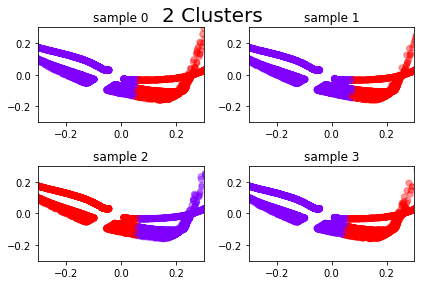



scores:
   clusters  mean score    std
0    2.0000      0.4543 0.0071
1    3.0000      0.4779 0.0036


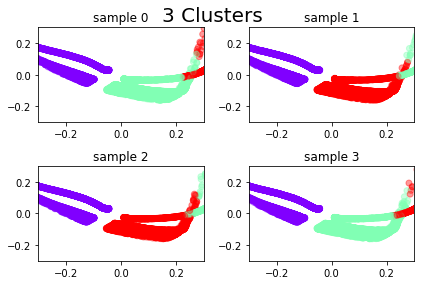



scores:
   clusters  mean score    std
0    2.0000      0.4543 0.0071
1    3.0000      0.4779 0.0036
2    4.0000      0.4952 0.0020


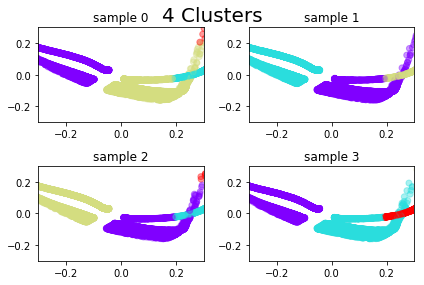



scores:
   clusters  mean score    std
0    2.0000      0.4543 0.0071
1    3.0000      0.4779 0.0036
2    4.0000      0.4952 0.0020
3    5.0000      0.4377 0.0239


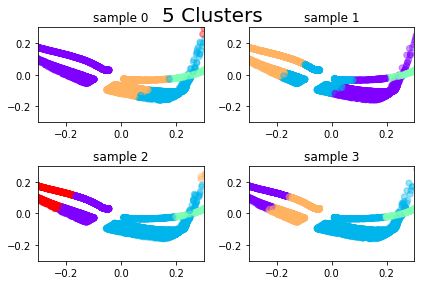



scores:
   clusters  mean score    std
0    2.0000      0.4543 0.0071
1    3.0000      0.4779 0.0036
2    4.0000      0.4952 0.0020
3    5.0000      0.4377 0.0239
4    6.0000      0.4507 0.0030


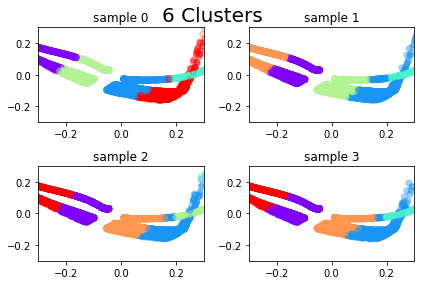



scores:
   clusters  mean score    std
0    2.0000      0.4543 0.0071
1    3.0000      0.4779 0.0036
2    4.0000      0.4952 0.0020
3    5.0000      0.4377 0.0239
4    6.0000      0.4507 0.0030
5    7.0000      0.5278 0.0035


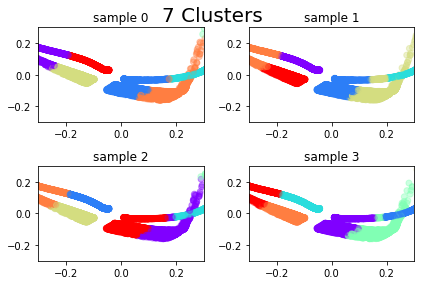



scores:
   clusters  mean score    std
0    2.0000      0.4543 0.0071
1    3.0000      0.4779 0.0036
2    4.0000      0.4952 0.0020
3    5.0000      0.4377 0.0239
4    6.0000      0.4507 0.0030
5    7.0000      0.5278 0.0035
6    8.0000      0.5332 0.0022


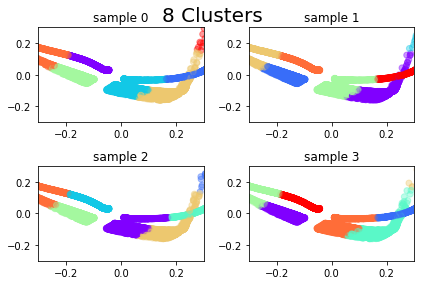



scores:
   clusters  mean score    std
0    2.0000      0.4543 0.0071
1    3.0000      0.4779 0.0036
2    4.0000      0.4952 0.0020
3    5.0000      0.4377 0.0239
4    6.0000      0.4507 0.0030
5    7.0000      0.5278 0.0035
6    8.0000      0.5332 0.0022
7    9.0000      0.5580 0.0014


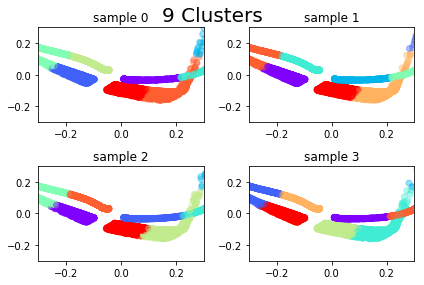



scores:
   clusters  mean score    std
0    2.0000      0.4543 0.0071
1    3.0000      0.4779 0.0036
2    4.0000      0.4952 0.0020
3    5.0000      0.4377 0.0239
4    6.0000      0.4507 0.0030
5    7.0000      0.5278 0.0035
6    8.0000      0.5332 0.0022
7    9.0000      0.5580 0.0014
8   10.0000      0.5539 0.0063


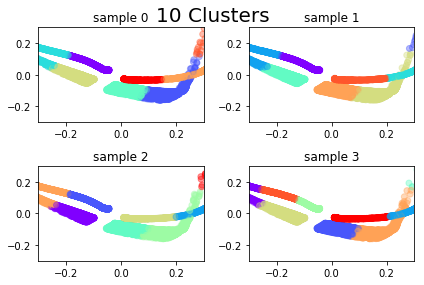



scores:
   clusters  mean score    std
0    2.0000      0.4543 0.0071
1    3.0000      0.4779 0.0036
2    4.0000      0.4952 0.0020
3    5.0000      0.4377 0.0239
4    6.0000      0.4507 0.0030
5    7.0000      0.5278 0.0035
6    8.0000      0.5332 0.0022
7    9.0000      0.5580 0.0014
8   10.0000      0.5539 0.0063
9   11.0000      0.5559 0.0017


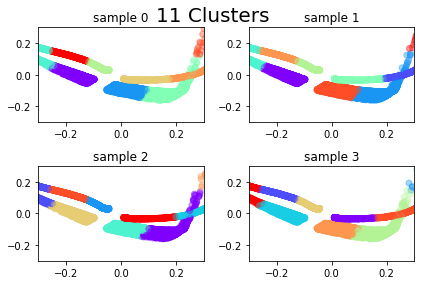



scores:
    clusters  mean score    std
0     2.0000      0.4543 0.0071
1     3.0000      0.4779 0.0036
2     4.0000      0.4952 0.0020
3     5.0000      0.4377 0.0239
4     6.0000      0.4507 0.0030
5     7.0000      0.5278 0.0035
6     8.0000      0.5332 0.0022
7     9.0000      0.5580 0.0014
8    10.0000      0.5539 0.0063
9    11.0000      0.5559 0.0017
10   12.0000      0.5552 0.0111


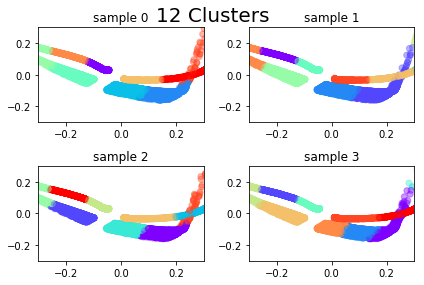



scores:
    clusters  mean score    std
0     2.0000      0.4543 0.0071
1     3.0000      0.4779 0.0036
2     4.0000      0.4952 0.0020
3     5.0000      0.4377 0.0239
4     6.0000      0.4507 0.0030
5     7.0000      0.5278 0.0035
6     8.0000      0.5332 0.0022
7     9.0000      0.5580 0.0014
8    10.0000      0.5539 0.0063
9    11.0000      0.5559 0.0017
10   12.0000      0.5552 0.0111
11   13.0000      0.5490 0.0124


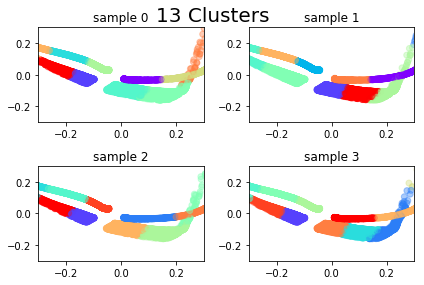



scores:
    clusters  mean score    std
0     2.0000      0.4543 0.0071
1     3.0000      0.4779 0.0036
2     4.0000      0.4952 0.0020
3     5.0000      0.4377 0.0239
4     6.0000      0.4507 0.0030
5     7.0000      0.5278 0.0035
6     8.0000      0.5332 0.0022
7     9.0000      0.5580 0.0014
8    10.0000      0.5539 0.0063
9    11.0000      0.5559 0.0017
10   12.0000      0.5552 0.0111
11   13.0000      0.5490 0.0124
12   14.0000      0.5488 0.0129


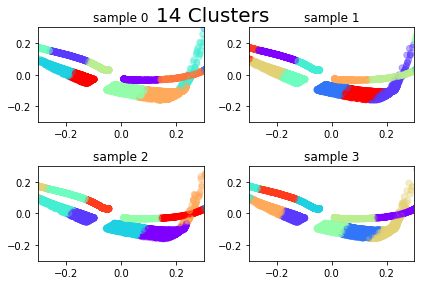



scores:
    clusters  mean score    std
0     2.0000      0.4543 0.0071
1     3.0000      0.4779 0.0036
2     4.0000      0.4952 0.0020
3     5.0000      0.4377 0.0239
4     6.0000      0.4507 0.0030
5     7.0000      0.5278 0.0035
6     8.0000      0.5332 0.0022
7     9.0000      0.5580 0.0014
8    10.0000      0.5539 0.0063
9    11.0000      0.5559 0.0017
10   12.0000      0.5552 0.0111
11   13.0000      0.5490 0.0124
12   14.0000      0.5488 0.0129
13   15.0000      0.5448 0.0031


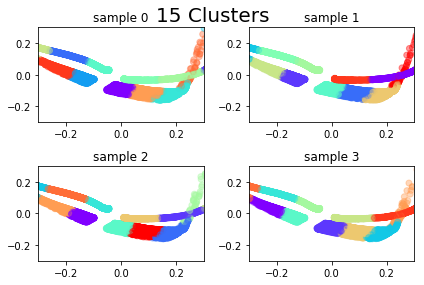



scores:
    clusters  mean score    std
0     2.0000      0.4543 0.0071
1     3.0000      0.4779 0.0036
2     4.0000      0.4952 0.0020
3     5.0000      0.4377 0.0239
4     6.0000      0.4507 0.0030
5     7.0000      0.5278 0.0035
6     8.0000      0.5332 0.0022
7     9.0000      0.5580 0.0014
8    10.0000      0.5539 0.0063
9    11.0000      0.5559 0.0017
10   12.0000      0.5552 0.0111
11   13.0000      0.5490 0.0124
12   14.0000      0.5488 0.0129
13   15.0000      0.5448 0.0031
14   16.0000      0.5455 0.0021


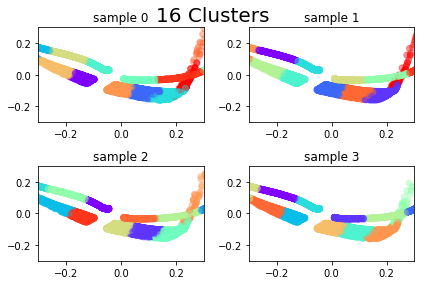



scores:
    clusters  mean score    std
0     2.0000      0.4543 0.0071
1     3.0000      0.4779 0.0036
2     4.0000      0.4952 0.0020
3     5.0000      0.4377 0.0239
4     6.0000      0.4507 0.0030
5     7.0000      0.5278 0.0035
6     8.0000      0.5332 0.0022
7     9.0000      0.5580 0.0014
8    10.0000      0.5539 0.0063
9    11.0000      0.5559 0.0017
10   12.0000      0.5552 0.0111
11   13.0000      0.5490 0.0124
12   14.0000      0.5488 0.0129
13   15.0000      0.5448 0.0031
14   16.0000      0.5455 0.0021
15   17.0000      0.5401 0.0102


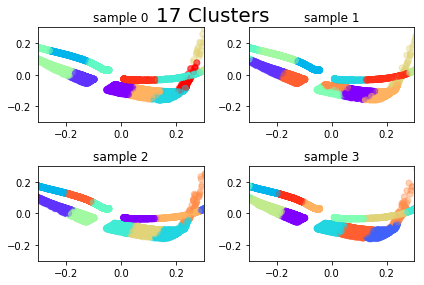



scores:
    clusters  mean score    std
0     2.0000      0.4543 0.0071
1     3.0000      0.4779 0.0036
2     4.0000      0.4952 0.0020
3     5.0000      0.4377 0.0239
4     6.0000      0.4507 0.0030
5     7.0000      0.5278 0.0035
6     8.0000      0.5332 0.0022
7     9.0000      0.5580 0.0014
8    10.0000      0.5539 0.0063
9    11.0000      0.5559 0.0017
10   12.0000      0.5552 0.0111
11   13.0000      0.5490 0.0124
12   14.0000      0.5488 0.0129
13   15.0000      0.5448 0.0031
14   16.0000      0.5455 0.0021
15   17.0000      0.5401 0.0102
16   18.0000      0.5333 0.0172


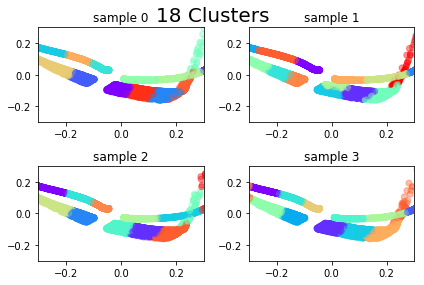



scores:
    clusters  mean score    std
0     2.0000      0.4543 0.0071
1     3.0000      0.4779 0.0036
2     4.0000      0.4952 0.0020
3     5.0000      0.4377 0.0239
4     6.0000      0.4507 0.0030
5     7.0000      0.5278 0.0035
6     8.0000      0.5332 0.0022
7     9.0000      0.5580 0.0014
8    10.0000      0.5539 0.0063
9    11.0000      0.5559 0.0017
10   12.0000      0.5552 0.0111
11   13.0000      0.5490 0.0124
12   14.0000      0.5488 0.0129
13   15.0000      0.5448 0.0031
14   16.0000      0.5455 0.0021
15   17.0000      0.5401 0.0102
16   18.0000      0.5333 0.0172
17   19.0000      0.5293 0.0090


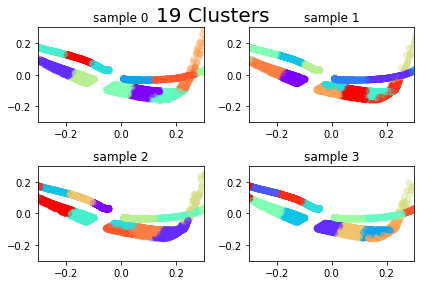



scores:
    clusters  mean score    std
0     2.0000      0.4543 0.0071
1     3.0000      0.4779 0.0036
2     4.0000      0.4952 0.0020
3     5.0000      0.4377 0.0239
4     6.0000      0.4507 0.0030
5     7.0000      0.5278 0.0035
6     8.0000      0.5332 0.0022
7     9.0000      0.5580 0.0014
8    10.0000      0.5539 0.0063
9    11.0000      0.5559 0.0017
10   12.0000      0.5552 0.0111
11   13.0000      0.5490 0.0124
12   14.0000      0.5488 0.0129
13   15.0000      0.5448 0.0031
14   16.0000      0.5455 0.0021
15   17.0000      0.5401 0.0102
16   18.0000      0.5333 0.0172
17   19.0000      0.5293 0.0090
18   20.0000      0.5231 0.0014


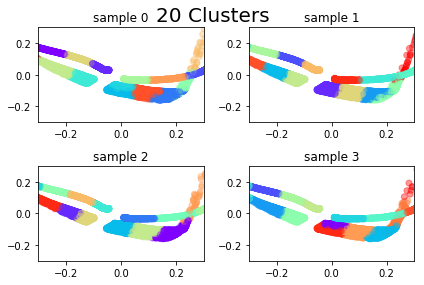



sorted cluster scores:
    clusters  mean score    std
7     9.0000      0.5580 0.0014
9    11.0000      0.5559 0.0017
10   12.0000      0.5552 0.0111
8    10.0000      0.5539 0.0063
11   13.0000      0.5490 0.0124
12   14.0000      0.5488 0.0129
14   16.0000      0.5455 0.0021
13   15.0000      0.5448 0.0031
15   17.0000      0.5401 0.0102
16   18.0000      0.5333 0.0172
6     8.0000      0.5332 0.0022
17   19.0000      0.5293 0.0090
5     7.0000      0.5278 0.0035
18   20.0000      0.5231 0.0014
2     4.0000      0.4952 0.0020
1     3.0000      0.4779 0.0036
0     2.0000      0.4543 0.0071
4     6.0000      0.4507 0.0030
3     5.0000      0.4377 0.0239
best cluster num:
9

--- 159.66226840019226 seconds ---


In [36]:
import time
start_time = time.time()

pd.options.display.float_format = '{:,.5f}'.format

boston2014_numerical_best_cluster_num = evaluate_kmeans(X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4, 21)


print("\n--- %s seconds ---" % (time.time() - start_time))

Using 9 clusters gave the highest mean silhouette score (0.558) and the smallest standard deviation (0.001). Not only did it perform the best out of all the iterations, it also performed the most consistently every time. Let's take a deeper look into some summary statistics for each of these 9 clusters.

In [40]:
def investigate_kmeans(X, best_cluster_num):
    best_cluster_pred = KMeans(n_clusters=best_cluster_num, random_state=42).fit_predict(X)
    X_pred = X.copy()
    X_pred['cluster_assignment'] = best_cluster_pred

    cluster_dataframes = {}
    for n_clust in range(best_cluster_num):
        cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]

    for name, frame in cluster_dataframes.items():
        print('\nCLUSTER NO: ',name)
        print(frame.describe())
        
    return X_pred

import time
start_time = time.time()

boston2014_numerical_pred = investigate_kmeans(boston2014_numerical, boston2014_numerical_best_cluster_num)

print("\n--- %s seconds ---" % (time.time() - start_time))


CLUSTER NO:  0
             10k   division        25k        age   official   genderdiv  \
count 2,473.0000 2,473.0000 2,473.0000 2,473.0000 2,473.0000  2,473.0000   
mean     64.5012 5,861.0736   174.4055    30.8015   324.4701 14,079.0437   
std       5.8939   550.9386    17.5662     5.1907    29.1535  1,754.7279   
min      44.9000 4,870.0000   117.7800    18.0000   282.3800 11,309.0000   
25%      60.8000 5,478.0000   162.0200    27.0000   301.0800 12,612.0000   
50%      64.0800 5,788.0000   172.0700    31.0000   318.6000 13,810.0000   
75%      68.0500 6,305.0000   185.0700    35.0000   341.5000 15,629.0000   
max      94.4500 6,979.0000   281.8500    39.0000   534.2200 17,574.0000   

             35k     overall       pace        30k         5k       half  \
count 2,473.0000  2,473.0000 2,473.0000 2,473.0000 2,473.0000 2,473.0000   
mean    263.0079 28,746.8071    12.3839   217.3895    31.7569   142.7720   
std      25.0944  1,732.9567     1.1120    21.6249     2.8186    14.014

max     116.8200   227.1500     1.0000     0.0000              8.0000  

--- 2.058535099029541 seconds ---


CLUSTER 0:
For the first cluster, some things I noticed are that the general mean to standard deviation ratio is about 10:1. The standard deviation was comparatively small for the category "overall", which relates to their ranking. The mean ranking here was 28735, which is pretty low considering the 31648 datapoints. Gender is fairly even with a 0.587 mean and 0.492 standard deviation. The standard deviation was also low for the 5k mark, and high for age. This cluster has the lowest mean age at 31. These people might be beginner runners -- they are the youngest cluster so they may have fewer years of experience under their belt.<br>

CLUSTER 1:
For the 2nd cluster, the standard deviation on all the timing checkpoints were much lower, ranging from a mean to standard deviation ratio of 20:1 to 40:1. The SD for the pace was also extremely low (0.22 for a mean of 8). The gender was consistently male here. The standard deviation for the rank was very high (9267) considering the rest of the values. This cluster has the second lowest mean age at 36.

CLUSTER 2:
The 3rd cluster also had an even gender divide, with standard deviations on most categories in the 1:15 range. The mean rank was 18925. I am reminded here that overall rank does not determine the athletic ability of the candidate, because men and women are judged by different standards. I might re-run this analysis after separating male and female.

CLUSTER 3:
Looking at the 4th cluster has showed me that pace seems to have consistently small standard deviations for pace. Perhaps the algorithm is clustering by pace? The standard deviation for the overall rank is HUGE, 1458 SD compared to 2340 mean. This cluster has more women than men, but there is a strong standard deviation here. This cluster is basically tied for the second lowest mean age at 36, and has the highest mean rank out of all the clusters (2340). This makes sense because younger people tend to be more athletic.

CLUSTER 4:
Cluster 5 is all women, with standard deviation ratios around 1:10 to 1:20. The overall rank here was 12319, which is right in the middle of the pack. This might mean that this area is where a large portion of the female contestants lie, as the few standout contestants placed in other clusters where they mixed in with male contestants. The highest-ranking female contestant had an overall rank of 21.

CLUSTER 5:
Cluster 6 is a mix, an overall rank of 28916 with a 17% standard deviation. These contestants have the lowest mean ranking of all the clusters (28916). I am also noticing here that not every cluster is the same size, which is how I thought k-means worked? Mean/standard deviation ratios for this cluster are typically around 20:1, with more consistency than other clusters.

CLUSTER 6:
The 7th cluster is made up of slightly higher ranking contestants than cluster 6, with an average of 23636 (still towards the bottom of the pool). The gender distribution is evenly divided in this cluster, and standard deviation ratios vary amongst features.

CLUSTER 7:
Cluster 8 is fairly high ranking with an overall ranking of 6608, but it has a very high standard deviation at 1490. This cluster is entirely made up of women, so this must be the highest ranking cluster of women. The official finishing time was 200.

CLUSTER 8:
The 9th and final cluster is made up of all women with mid-range rankings. The mean official finishing time was 228. The standard deviation ratios varied a lot.

Although there are obvious differences between our clusters, 9 clusters of mixed gender and age doesn't really tell us much about our data. Additionally, the mean silhouette score was only 0.558, which is not great. Given our background knowledge, we know that male and female contestants perform differently, so:
>we could try separating between male and female, then running the clustering algorithm again.

(17484, 16)
scores:
   clusters  mean score    std
0    2.0000      0.6458 0.0037


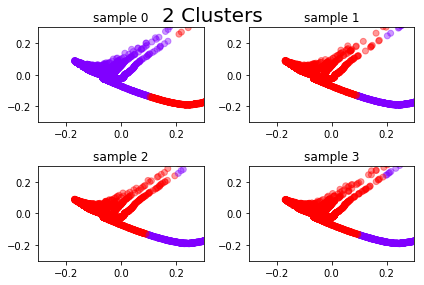



scores:
   clusters  mean score    std
0    2.0000      0.6458 0.0037
1    3.0000      0.6392 0.0034


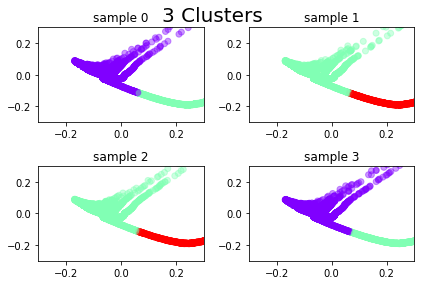



scores:
   clusters  mean score    std
0    2.0000      0.6458 0.0037
1    3.0000      0.6392 0.0034
2    4.0000      0.5256 0.0026


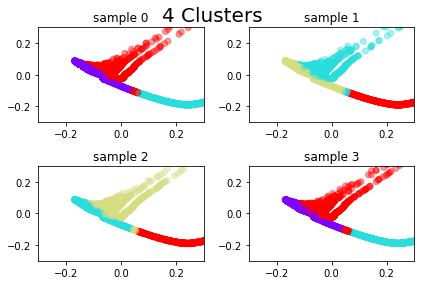



scores:
   clusters  mean score    std
0    2.0000      0.6458 0.0037
1    3.0000      0.6392 0.0034
2    4.0000      0.5256 0.0026
3    5.0000      0.5333 0.0015


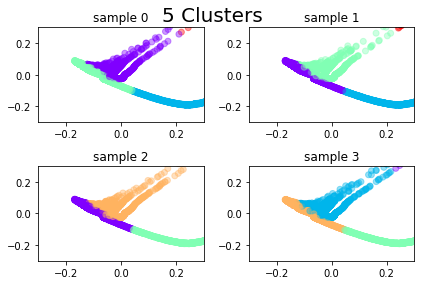



scores:
   clusters  mean score    std
0    2.0000      0.6458 0.0037
1    3.0000      0.6392 0.0034
2    4.0000      0.5256 0.0026
3    5.0000      0.5333 0.0015
4    6.0000      0.5412 0.0018


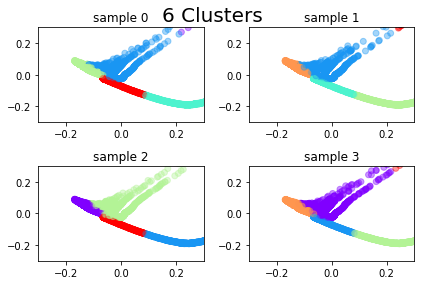



scores:
   clusters  mean score    std
0    2.0000      0.6458 0.0037
1    3.0000      0.6392 0.0034
2    4.0000      0.5256 0.0026
3    5.0000      0.5333 0.0015
4    6.0000      0.5412 0.0018
5    7.0000      0.5349 0.0069


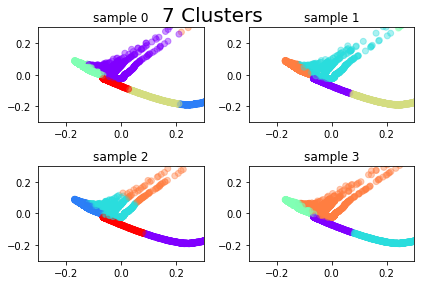



scores:
   clusters  mean score    std
0    2.0000      0.6458 0.0037
1    3.0000      0.6392 0.0034
2    4.0000      0.5256 0.0026
3    5.0000      0.5333 0.0015
4    6.0000      0.5412 0.0018
5    7.0000      0.5349 0.0069
6    8.0000      0.5355 0.0046


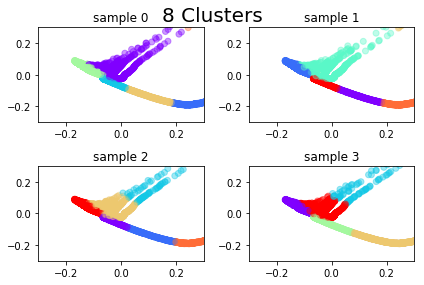



scores:
   clusters  mean score    std
0    2.0000      0.6458 0.0037
1    3.0000      0.6392 0.0034
2    4.0000      0.5256 0.0026
3    5.0000      0.5333 0.0015
4    6.0000      0.5412 0.0018
5    7.0000      0.5349 0.0069
6    8.0000      0.5355 0.0046
7    9.0000      0.5229 0.0150


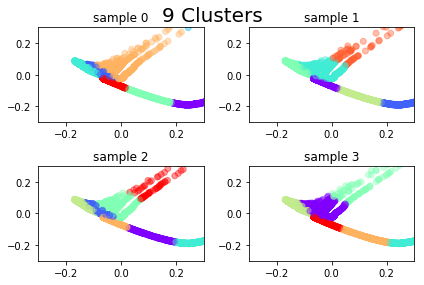



scores:
   clusters  mean score    std
0    2.0000      0.6458 0.0037
1    3.0000      0.6392 0.0034
2    4.0000      0.5256 0.0026
3    5.0000      0.5333 0.0015
4    6.0000      0.5412 0.0018
5    7.0000      0.5349 0.0069
6    8.0000      0.5355 0.0046
7    9.0000      0.5229 0.0150
8   10.0000      0.5141 0.0049


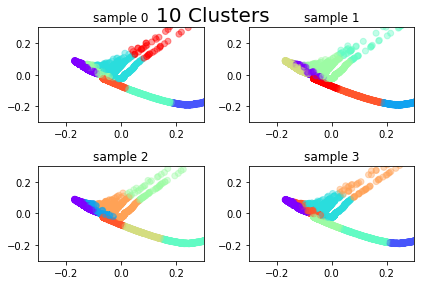



sorted cluster scores:
   clusters  mean score    std
0    2.0000      0.6458 0.0037
1    3.0000      0.6392 0.0034
4    6.0000      0.5412 0.0018
6    8.0000      0.5355 0.0046
5    7.0000      0.5349 0.0069
3    5.0000      0.5333 0.0015
2    4.0000      0.5256 0.0026
7    9.0000      0.5229 0.0150
8   10.0000      0.5141 0.0049
best cluster num:
2

CLUSTER NO:  0
             10k   division        25k        age   official   genderdiv  \
count 7,857.0000 7,857.0000 7,857.0000 7,857.0000 7,857.0000  7,857.0000   
mean     56.9278 2,409.1653   149.3467    47.7938   278.9989 13,557.1745   
std       7.0697 1,653.1670    21.2362    12.4233    41.0281  2,279.8837   
min      36.8700     1.0000    96.8300    18.0000   226.7200  9,579.0000   
25%      51.8800 1,107.0000   133.8000    39.0000   244.8800 11,582.0000   
50%      56.0700 2,058.0000   144.6700    48.0000   269.9800 13,556.0000   
75%      61.2700 3,920.0000   161.5300    57.0000   304.3200 15,532.0000   
max     112.3800 5,91

In [44]:
male_cont = boston2014_numerical.loc[boston2014_numerical['gender_1'] == 1]
m1, m_pca1, m2, m_pca2, m3, m_pca3, m4, m_pca4 = set_X_groups(male_cont)
male_best_cluster_num = evaluate_kmeans(m1, m_pca1, m2, m_pca2, m3, m_pca3, m4, m_pca4, 11)
male_pred = investigate_kmeans(male_cont, male_best_cluster_num)

The cluster arrangement with the highest score for the male group has **2 clusters** with a mean silhouette score of **0.646**, which is signficantly higher than the mean score for the combined group. This is good! The standard deviation is 3 times higher though, which means the algorithm did not cluster as consistently. Within these 2 clusters, there is a higher ranking group (overall ranking mean 6029) and a lower ranking group (overall ranking mean 23318). Both of these rankings have a standard deviation around 4500, which is very high. The lower ranking male group also has a higher average age, 44, compared to 40 for the higher ranking group.<br>

Let's try female.

(14164, 16)
scores:
   clusters  mean score    std
0    2.0000      0.4909 0.0050


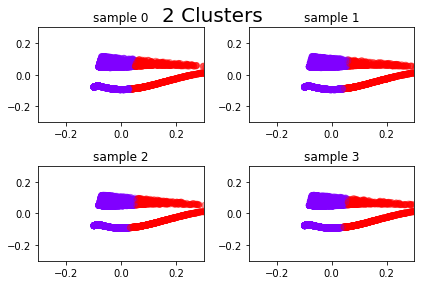



scores:
   clusters  mean score    std
0    2.0000      0.4909 0.0050
1    3.0000      0.5885 0.0033


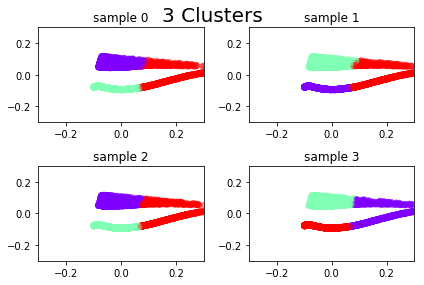



scores:
   clusters  mean score    std
0    2.0000      0.4909 0.0050
1    3.0000      0.5885 0.0033
2    4.0000      0.6004 0.0028


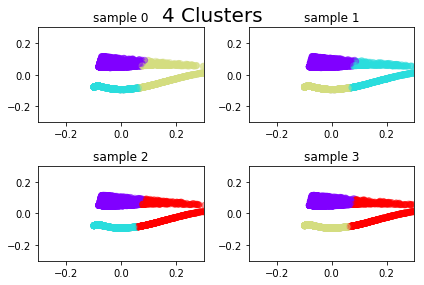



scores:
   clusters  mean score    std
0    2.0000      0.4909 0.0050
1    3.0000      0.5885 0.0033
2    4.0000      0.6004 0.0028
3    5.0000      0.6100 0.0030


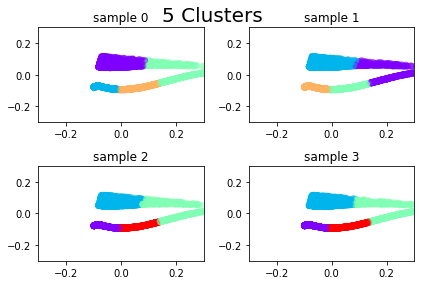



scores:
   clusters  mean score    std
0    2.0000      0.4909 0.0050
1    3.0000      0.5885 0.0033
2    4.0000      0.6004 0.0028
3    5.0000      0.6100 0.0030
4    6.0000      0.5974 0.0039


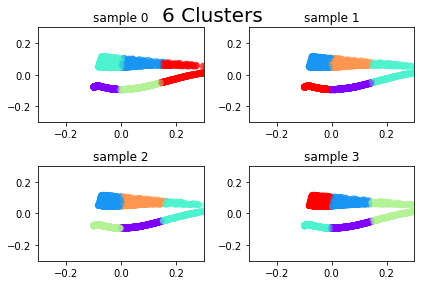



scores:
   clusters  mean score    std
0    2.0000      0.4909 0.0050
1    3.0000      0.5885 0.0033
2    4.0000      0.6004 0.0028
3    5.0000      0.6100 0.0030
4    6.0000      0.5974 0.0039
5    7.0000      0.5912 0.0063


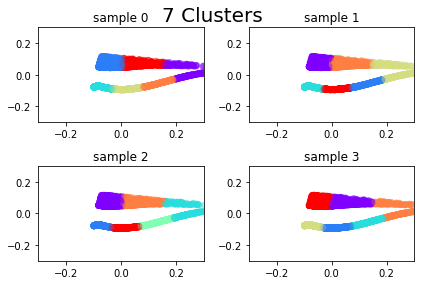



scores:
   clusters  mean score    std
0    2.0000      0.4909 0.0050
1    3.0000      0.5885 0.0033
2    4.0000      0.6004 0.0028
3    5.0000      0.6100 0.0030
4    6.0000      0.5974 0.0039
5    7.0000      0.5912 0.0063
6    8.0000      0.5812 0.0214


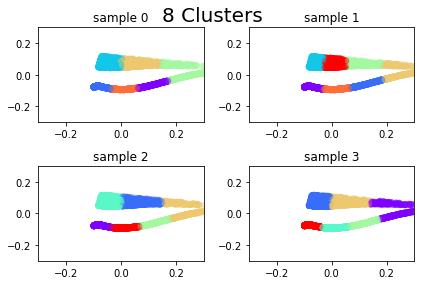



scores:
   clusters  mean score    std
0    2.0000      0.4909 0.0050
1    3.0000      0.5885 0.0033
2    4.0000      0.6004 0.0028
3    5.0000      0.6100 0.0030
4    6.0000      0.5974 0.0039
5    7.0000      0.5912 0.0063
6    8.0000      0.5812 0.0214
7    9.0000      0.5471 0.0066


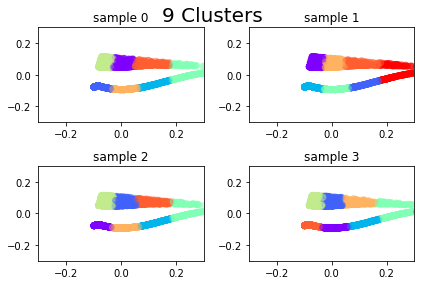



scores:
   clusters  mean score    std
0    2.0000      0.4909 0.0050
1    3.0000      0.5885 0.0033
2    4.0000      0.6004 0.0028
3    5.0000      0.6100 0.0030
4    6.0000      0.5974 0.0039
5    7.0000      0.5912 0.0063
6    8.0000      0.5812 0.0214
7    9.0000      0.5471 0.0066
8   10.0000      0.5432 0.0029


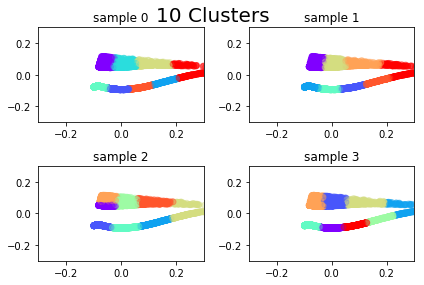



Sorted cluster silhouette scores:
   clusters  mean score    std
3    5.0000      0.6100 0.0030
2    4.0000      0.6004 0.0028
4    6.0000      0.5974 0.0039
5    7.0000      0.5912 0.0063
1    3.0000      0.5885 0.0033
6    8.0000      0.5812 0.0214
7    9.0000      0.5471 0.0066
8   10.0000      0.5432 0.0029
0    2.0000      0.4909 0.0050
best cluster num:
5

CLUSTER NO:  0
             10k   division        25k        age   official  genderdiv  \
count 3,055.0000 3,055.0000 3,055.0000 3,055.0000 3,055.0000 3,055.0000   
mean     49.2417 1,481.9018   125.1747    38.5057   220.3340 3,741.2337   
std       2.0746 1,056.5115     4.0900     8.7214     5.3491   887.3919   
min      38.5000     1.0000   101.9800    18.0000   210.5500 2,179.0000   
25%      47.9300   461.5000   122.5800    32.0000   215.8800 2,974.5000   
50%      49.2500 1,699.0000   125.0300    39.0000   220.3500 3,739.0000   
75%      50.6200 2,464.5000   127.9500    45.0000   224.9000 4,505.5000   
max      57.2700 3

In [46]:
female_cont = boston2014_numerical.loc[boston2014_numerical['gender_0'] == 1]


import time
start_time = time.time()

f1, f_pca1, f2, f_pca2, f3, f_pca3, f4, f_pca4 = set_X_groups(female_cont)
female_best_cluster_num = evaluate_kmeans(f1, f_pca1, f2, f_pca2, f3, f_pca3, f4, f_pca4, 11)
female_pred = investigate_kmeans(female_cont, female_best_cluster_num)


print("\n--- %s seconds ---" % (time.time() - start_time))

The female group looks best with **5 clusters** -- this gives a mean silhouette score of **0.61** and a standard deviation of 0.003, similar to that of the male group. The overall ranking varies by about 6000-7000 per group, splitting the female contestants into 5 groups of performers centered around rankings around 3000, 10000, 16000, 22000, and 29000. The highest ranking group has an average age of 34 then 38,42,43,39 (though the max age here was 81!)

Now that we have our clusters, let's look deeper into the features and see what we can find.

17


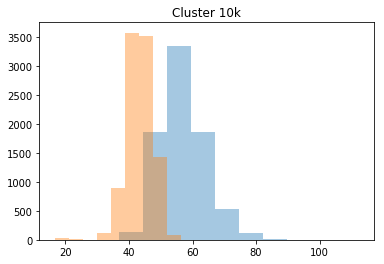

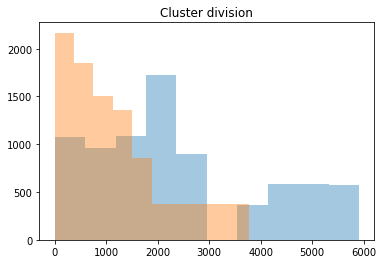

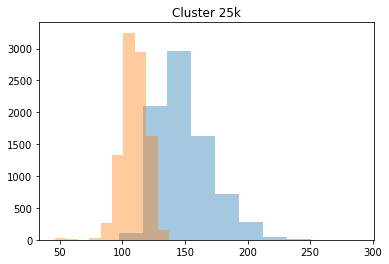

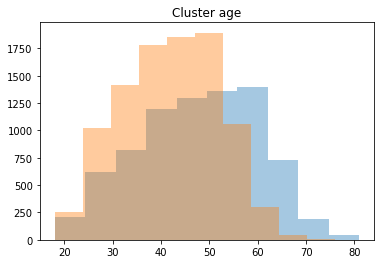

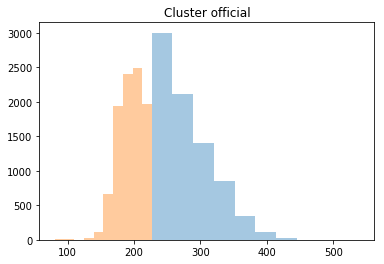

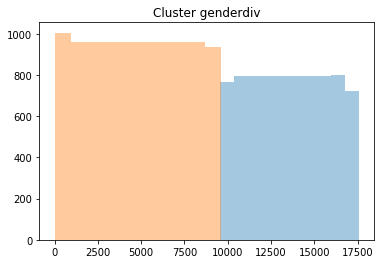

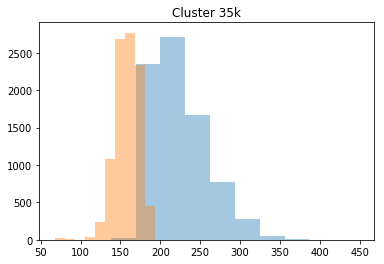

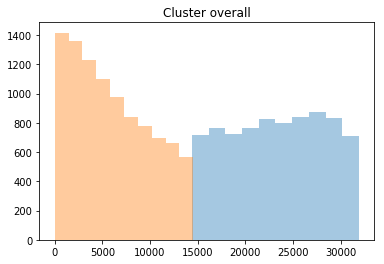

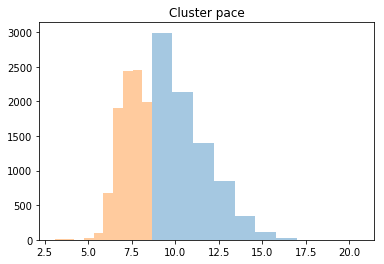

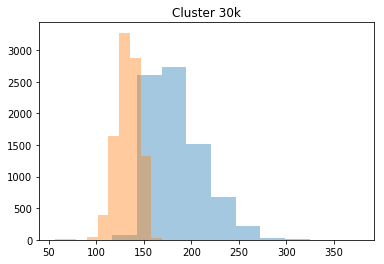

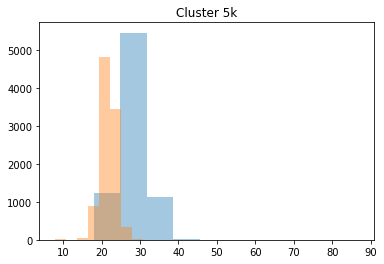

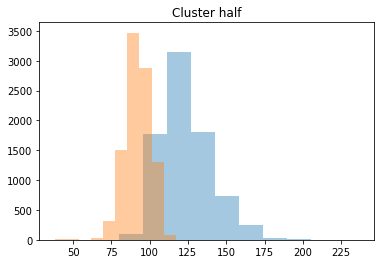

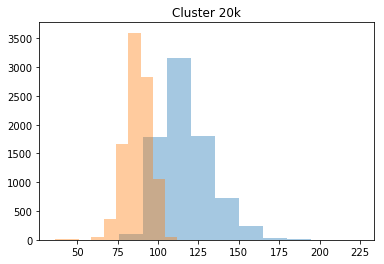

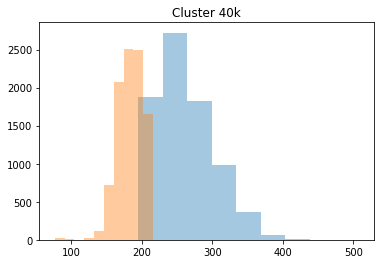

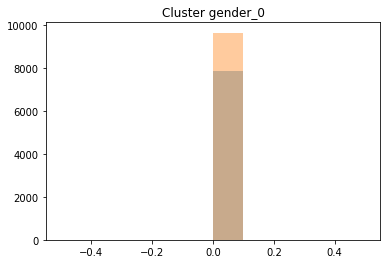

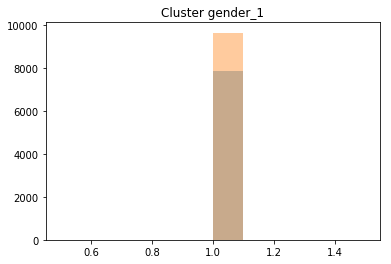

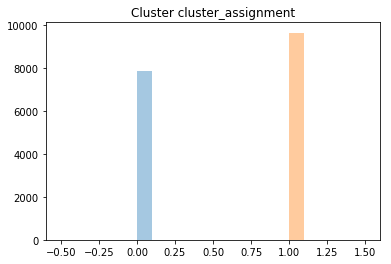

In [50]:
def plot_histo(X, best_cluster_num):
    cluster_dataframes = {}
    for n_clust in range(best_cluster_num):
         cluster_dataframes[n_clust] = X.loc[X['cluster_assignment'] == n_clust]
            
    print(len(X.columns))
    
    for column in X:
        for i in range(best_cluster_num):
            plt.hist(cluster_dataframes[i][column], alpha=0.4)
        plt.title('Cluster {column}'.format(column=column))
        plt.show()
            
plot_histo(male_pred, male_best_cluster_num)

For the male contestants: 5k timing has the lowest spread/variance, which makes sense because at this point the race has just started, so there is less time to stand out. As the distance increases, the faster contestants maintain a sharp peak, while the slower contestants gradually start dropping off and spreading the distribution. 

Light-orange is the better performing group, and blue is the worse performing group. The groups have significant overlap and a normal distribution for age, slight overlap for all the timing, and clear cutoffs for pace, overall ranking, and official finishing time.

17


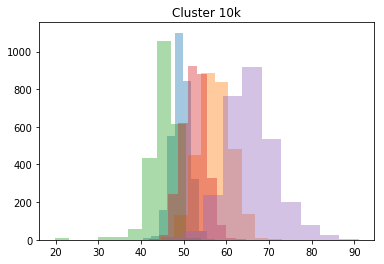

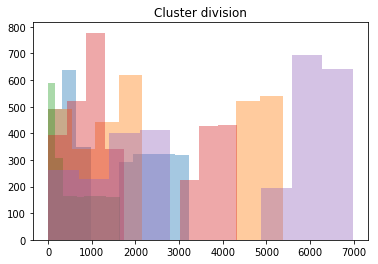

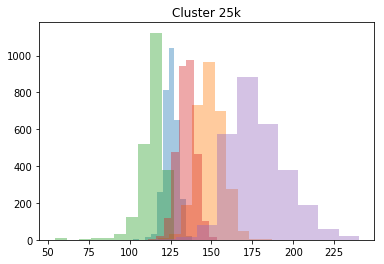

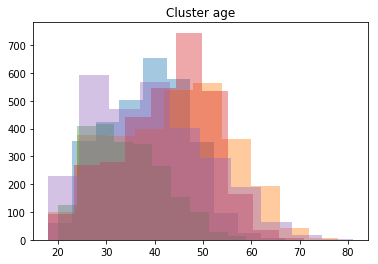

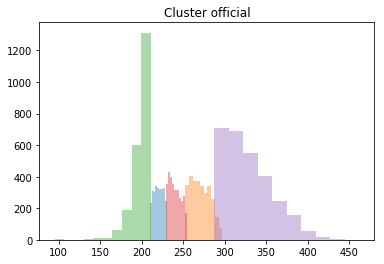

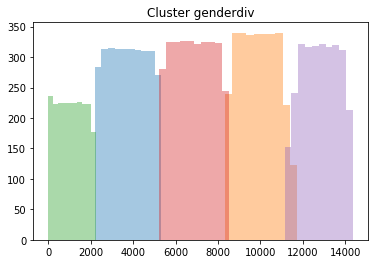

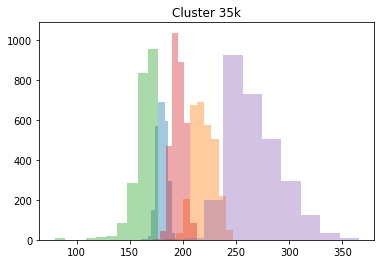

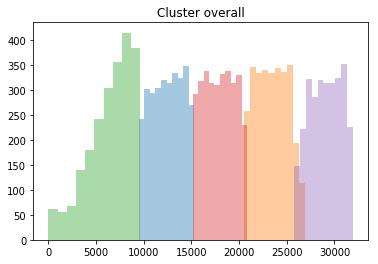

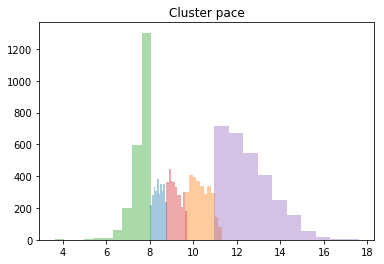

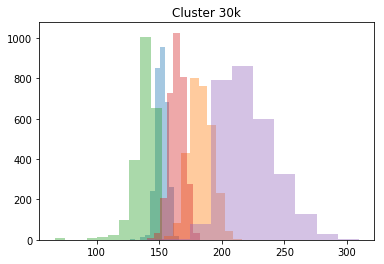

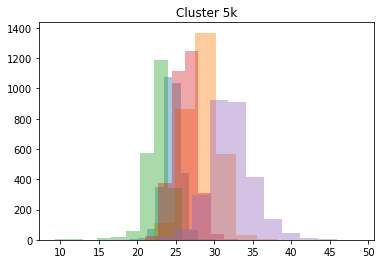

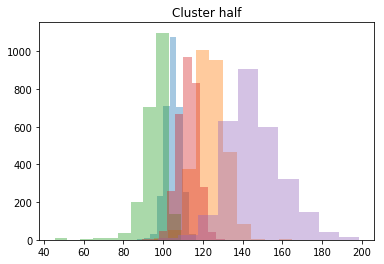

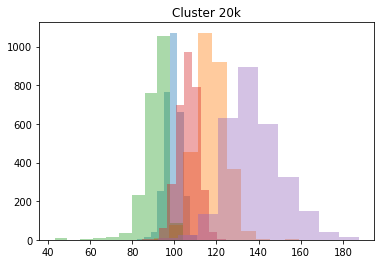

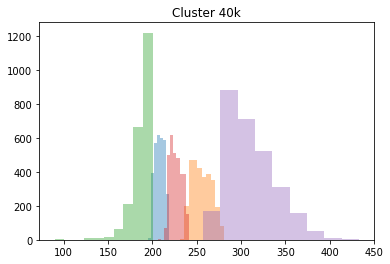

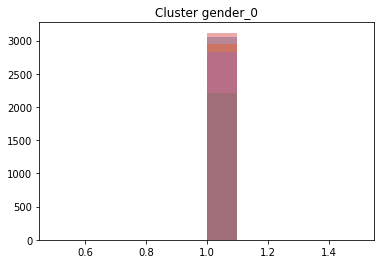

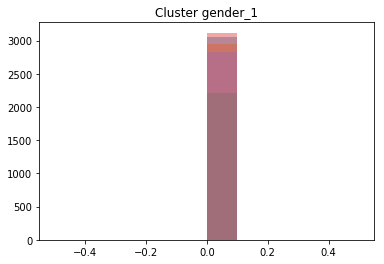

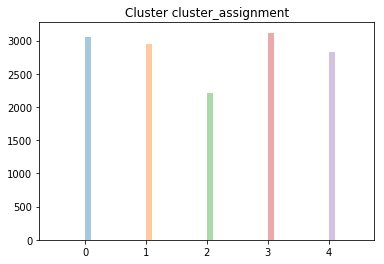

In [51]:
plot_histo(female_pred, female_best_cluster_num)

For the female clusters, the clusters consistently performed in this order (from best to worst): green, blue, light-red, gold, purple. Similarly to the male clusters, all of the plots for milestone timing revealed overlap between the clusters, while plots for pace, overall ranking, and official finish time have clear distinctions. The red group of highest performers tended to have the sharpest peaks, with contestants placing closer to eachother, while the lower groups had more widespread distributions. This makes sense because as we get into the clusters with slower times and lower rankings, women start diluting the pool.<br>

One interesting finding was that the green/blue/light-red/gold/purple order held true for every category except age, where red, blue, purple, and green were sequential but the gold group spread throughout all of these groups with a very wide distribution. The gold group, which was consistently the worst performing group, had runners as young as 18 and as old as 81. Though this surprised me at first, it makes sense considering that these are the most "newbie" marathoners, who are in it more for the sake of completing a marathon than for competition's sake. Marathon running is a culture that attracts young and old, and perhaps takes a few years of experience to start placing in higher-performing clusters.

I also found it interesting that despite having the same number of contestants for male and female, men clustered into 2 groups and women clustered into 5. With 5 clusters, you can be more specific, gathering metrics on each cluster without crazy standard deviations. 2 clusters seems like an oversimplification that masks some of the characteristics that distinguish the male contestants. Perhaps another clustering algorithm would work better; 
>let's try mean-shift clustering.

# Mean-Shift Clustering

The estimate_bandwidth function automatically derives a bandwidth based on an inspection of the distances among points in the data. The bandwidth is influenced by the quantile, which determines how much noise the probability surface is susceptible to. 

Higher bandwidths create a smoother kernel density surface, leading to fewer peaks because smaller hills are smoothed out, whereas lower bandwidths lead to a surface with more peaks – the same peaks spotted by the higher bandwidth, plus some lower peaks.

We will iterate through several quantile values to find the best results for mean-shift clustering.

In [55]:
quantiles = [0.2, 0.4, 0.6, 0.8]

def make_meanshift_data(X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4):

    plot_clusters = pd.DataFrame()

    for index, data in enumerate([
        (X1, X_pca1),
        (X2, X_pca2),
        (X3, X_pca3),
        (X4, X_pca4)]):

        plot_clusters['pca_f1' + '_sample' + str(index)] = data[1][:, 0]
        plot_clusters['pca_f2' + '_sample' + str(index)] = data[1][:, 1]
        
        for q in quantiles:
            bandwidth = estimate_bandwidth(data[0], quantile = q)
            ms = MeanShift(bandwidth = bandwidth)
            cluster_pred = ms.fit_predict(data[0])
            
            labels = ms.labels_
            cluster_centers = ms.cluster_centers_
            n_clusters_ = len(np.unique(labels))
            
            plot_clusters['quantile' + str(q) + '_sample' + str(index)] = cluster_pred
            plot_clusters['sil_score quantile' + str(q) + '_sample' + str(index)] = \
                                metrics.silhouette_score(data[0], labels, metric='euclidean')
            plot_clusters['n_clust quantile' + str(q) + '_sample' + str(index)] = n_clusters_
            
    return plot_clusters

female_plot_clusters = make_meanshift_data(f1, f_pca1, f2, f_pca2, f3, f_pca3, f4, f_pca4)

In [65]:
female_plot_clusters

,pca_f1_sample0,pca_f2_sample0,quantile0.2_sample0,sil_score quantile0.2_sample0,n_clust quantile0.2_sample0,quantile0.4_sample0,sil_score quantile0.4_sample0,n_clust quantile0.4_sample0,quantile0.6_sample0,sil_score quantile0.6_sample0,...,n_clust quantile0.2_sample3,quantile0.4_sample3,sil_score quantile0.4_sample3,n_clust quantile0.4_sample3,quantile0.6_sample3,sil_score quantile0.6_sample3,n_clust quantile0.6_sample3,quantile0.8_sample3,sil_score quantile0.8_sample3,n_clust quantile0.8_sample3
0,0.0486,-0.0870,1,0.4496,8,0,0.5492,5,0,0.8207,...,11,0,0.6414,5,0,0.6365,4,0,0.6742,4
1,-0.0728,0.0747,0,0.4496,8,0,0.5492,5,0,0.8207,...,11,0,0.6414,5,0,0.6365,4,0,0.6742,4
2,-0.0896,-0.0732,1,0.4496,8,0,0.5492,5,0,0.8207,...,11,0,0.6414,5,0,0.6365,4,0,0.6742,4
3,-0.0099,-0.0929,1,0.4496,8,0,0.5492,5,0,0.8207,...,11,0,0.6414,5,0,0.6365,4,0,0.6742,4
4,-0.0397,0.0788,0,0.4496,8,0,0.5492,5,0,0.8207,...,11,0,0.6414,5,0,0.6365,4,0,0.6742,4
5,-0.0481,0.0768,0,0.4496,8,0,0.5492,5,0,0.8207,...,11,0,0.6414,5,0,0.6365,4,0,0.6742,4
6,0.1336,-0.0563,1,0.4496,8,0,0.5492,5,0,0.8207,...,11,0,0.6414,5,0,0.6365,4,0,0.6742,4
7,-0.0916,-0.0737,1,0.4496,8,0,0.5492,5,0,0.8207,...,11,0,0.6414,5,0,0.6365,4,0,0.6742,4
8,-0.0249,0.0806,0,0.4496,8,0,0.5492,5,0,0.8207,...,11,0,0.6414,5,0,0.6365,4,0,0.6742,4
9,-0.0418,-0.0865,1,0.4496,8,0,0.5492,5,0,0.8207,...,11,0,0.6414,5,0,0.6365,4,0,0.6742,4


quantile silhouette scores:
   mean_estimated_clusters  mean score    std  quantile
0                   9.0000      0.4937 0.0361    0.2000


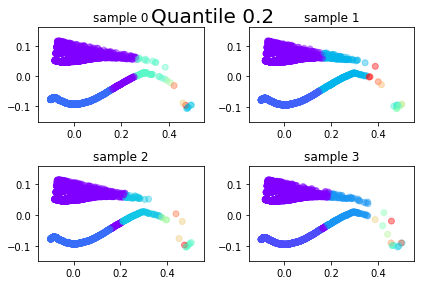



quantile silhouette scores:
   mean_estimated_clusters  mean score    std  quantile
0                   9.0000      0.4937 0.0361    0.2000
1                   4.5000      0.6157 0.0481    0.4000


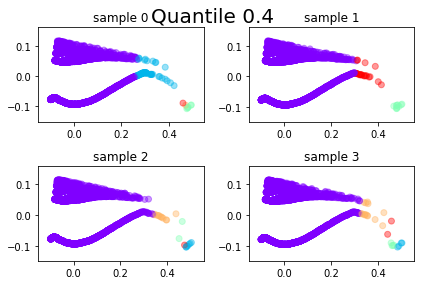



quantile silhouette scores:
   mean_estimated_clusters  mean score    std  quantile
0                   9.0000      0.4937 0.0361    0.2000
1                   4.5000      0.6157 0.0481    0.4000
2                   3.5000      0.7533 0.0998    0.6000


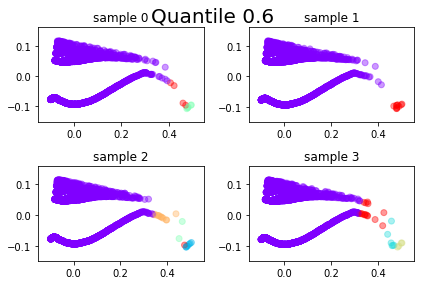



quantile silhouette scores:
   mean_estimated_clusters  mean score    std  quantile
0                   9.0000      0.4937 0.0361    0.2000
1                   4.5000      0.6157 0.0481    0.4000
2                   3.5000      0.7533 0.0998    0.6000
3                   3.0000      0.7912 0.0746    0.8000


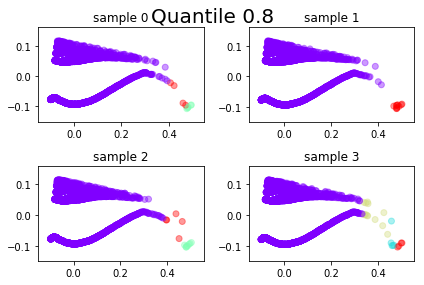



sorted quantile scores:
   mean_estimated_clusters  mean score    std  quantile
3                   3.0000      0.7912 0.0746    0.8000
2                   3.5000      0.7533 0.0998    0.6000
1                   4.5000      0.6157 0.0481    0.4000
0                   9.0000      0.4937 0.0361    0.2000
best cluster num:
3
best quantile:
0.8


In [62]:
def plot_meanshift(plot_clusters):

    quantiles = [0.2, 0.4, 0.6, 0.8]
    quantile_scores = pd.DataFrame(columns=['mean_estimated_clusters','mean score','std'])
    
    for q in quantiles:
        f, plotgrid = plt.subplots(2, 2)
        cluster_estimates = []
        sil_scores = []

        for i in range(4):

            #current_group = f'quantile{q}_sample{i}'
            current_group = 'quantile{q}_sample{i}'.format(q=q,i=i)
            
            num_clust_column = 'n_clust {current_group}'.format(current_group=current_group)
            num_colors = int(plot_clusters[num_clust_column].max())
            colors = cm.rainbow(np.linspace(0, 1, num_colors))

            x_plot = plot_clusters['pca_f1_sample{i}'.format(i=i)]
            y_plot = plot_clusters['pca_f2_sample{i}'.format(i=i)]

            c = plot_clusters[current_group]

            rows = int(np.floor(i / 2))
                # 0,0,1,1
            cols = i % 2
                # 0,1,0,1

            plotgrid[rows, cols].scatter(x_plot, y_plot, color = colors[c], alpha = 0.4)
            plotgrid[rows, cols].set_title('sample {i}'.format(i=i))
            #plotgrid[rows, cols].set_xlim([-.3, .3])
            #plotgrid[rows, cols].set_ylim([-.3, .3])

            sil_score = plot_clusters['sil_score ' + str(current_group)].mean()
            sil_scores.append(sil_score)
            cluster_estimate = plot_clusters['n_clust ' + str(current_group)].mean()
            cluster_estimates.append(cluster_estimate)

        group_sil_scores_mean = np.mean(sil_scores)
        group_sil_scores_std = np.std(sil_scores)
        group_cluster_estimate = np.mean(cluster_estimates)
        quantile_scores = quantile_scores.append({'mean_estimated_clusters': group_cluster_estimate
                                                  , 'quantile':q
                                                  , 'mean score': group_sil_scores_mean
                                                  , 'std': group_sil_scores_std
                                                 }
                                                 , ignore_index=True
                                                )
        print('quantile silhouette scores:')
        print(quantile_scores)

        plt.suptitle('Quantile {q}'.format(q=q), fontsize=20)
        plt.tight_layout()
        plt.show()
        print('\n')

    print('sorted quantile scores:')
    sorted_scores = quantile_scores.sort_values(by = ['mean score'], ascending = False)
    print(sorted_scores)

    best_cluster_num = int(sorted_scores['mean_estimated_clusters'].iloc[0])
    print('best cluster num:')
    print(best_cluster_num)
    
    best_quantile = sorted_scores['quantile'].iloc[0]
    print('best quantile:')
    print(best_quantile)

    return best_quantile
        
female_ms_quantile = plot_meanshift(female_plot_clusters)

With a quantile of 0.8, we get 3 clusters with a mean silhouette score of 0.79 and a standard deviation of 0.07. This is different than the number of clusters that we arrived at using k-means(5), with a higher silhouette score but a higher standard deviation.

I do find it interesting that with other quantile values, we did not see consistent clustering (each quadrant had varying numbers of clusters). This shows that this clustering algorithm may not be very stable. 

>Let's look inside the clusters for the best performing quantile value (quantile=0.8) to see how they compare to the previous k-means clusters.

In [64]:
def investigate_ms(X, best_quantile):
    bandwidth = estimate_bandwidth(X, quantile = best_quantile)
    print('Bandwidth: {bandwidth}'.format(bandwidth=bandwidth))
    ms = MeanShift(bandwidth=bandwidth)
    best_cluster_pred = ms.fit_predict(X)

    X_pred = X.copy()
    X_pred['cluster_assignment'] = best_cluster_pred
    
    cluster_dataframes = {}
    for n_clust in X_pred['cluster_assignment'].unique():
        cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]

    for name, frame in cluster_dataframes.items():
        print(name)
        print(frame.describe())
        
    return X_pred

import time
start_time = time.time()

female_2014_pred_ms = investigate_ms(female_cont, female_ms_quantile)

print("\n--- %s seconds ---" % (time.time() - start_time))

Bandwidth: 17048.533815778304
0
              10k    division         25k         age    official   genderdiv  \
count 14,165.0000 14,165.0000 14,165.0000 14,165.0000 14,165.0000 14,165.0000   
mean      54.3146  2,157.1089    141.1155     39.7638    253.5524  7,111.5425   
std        7.8193  1,945.6577     23.5827     10.4984     46.5693  4,115.0176   
min       19.7500      1.0000     54.1800     18.0000     95.1000      1.0000   
25%       48.6700    614.0000    124.1800     31.0000    219.1500  3,546.0000   
50%       52.7000  1,471.0000    135.5000     40.0000    241.6500  7,109.0000   
75%       58.9800  3,367.0000    153.8700     47.0000    280.7300 10,675.0000   
max       91.0800  6,979.0000    240.0200     81.0000    461.8700 14,355.0000   

              35k     overall        pace         30k          5k        half  \
count 14,165.0000 14,165.0000 14,165.0000 14,165.0000 14,165.0000 14,165.0000   
mean     206.5205 18,345.8169      9.6790    173.0321     26.9611    117.372

Interestingly, the same algorithm that consistently revealed 2 clusters for each of the 4 data subsets gave only 1 cluster when applied to the entire dataset. The quantile score that gave the best and most consistent results for the four quadrants was 0.8, which is decently high. When using this to compute bandwidth for the entire dataset, we get an extreme value of ~17000. This would cause our probability peaks to be very large and very smooth, which explains the singular cluster. Quantile=0.8 is perhaps only clustering consistently because the probability peaks are so simple.<br>

Let's see what happens when we use the second best quantile score, quantile=0.6.

We may wish to stick with our clustering results from K-Means. However, we will still run Mean Shift on the male dataset to confirm.

In [66]:
start_time = time.time()

investigate_ms(female_cont, 0.6)

print("\n--- %s seconds ---" % (time.time() - start_time))

Bandwidth: 12029.179286577712
0
              10k    division         25k         age    official   genderdiv  \
count 14,165.0000 14,165.0000 14,165.0000 14,165.0000 14,165.0000 14,165.0000   
mean      54.3146  2,157.1089    141.1155     39.7638    253.5524  7,111.5425   
std        7.8193  1,945.6577     23.5827     10.4984     46.5693  4,115.0176   
min       19.7500      1.0000     54.1800     18.0000     95.1000      1.0000   
25%       48.6700    614.0000    124.1800     31.0000    219.1500  3,546.0000   
50%       52.7000  1,471.0000    135.5000     40.0000    241.6500  7,109.0000   
75%       58.9800  3,367.0000    153.8700     47.0000    280.7300 10,675.0000   
max       91.0800  6,979.0000    240.0200     81.0000    461.8700 14,355.0000   

              35k     overall        pace         30k          5k        half  \
count 14,165.0000 14,165.0000 14,165.0000 14,165.0000 14,165.0000 14,165.0000   
mean     206.5205 18,345.8169      9.6790    173.0321     26.9611    117.372